## Data Analysis
This notebook will be used to analyse data from Combination Lock experiments.

### Install Libraries

In [2]:
%%capture

%pip install matplotlib
%pip install pandas statsmodels
import json
import glob
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
%matplotlib inline
import matplotlib as mpl
import pandas as pd
from statsmodels.stats.anova import AnovaRM


### Read in Files

In [3]:
log_dir = './docs/evaluation-logs/*'
filepaths = glob.glob(log_dir)

files = []

for path in filepaths:
    with open(path) as f:
        files.append(json.load(f)['data'])

### Extract Data Across Participants into Single Dict

In [4]:
fullDict = {}


for f in files:
    fullDict = fullDict | f

print(len(fullDict))

42


### Traverse entire dataset, adding each list to the appropraite method list

In [5]:
methodsDict = {'tap6':[], 'tap10':[], 'direction6':[], 'direction10':[], 'pin':[],'pattern':[]}

for key in fullDict.keys():
    method = fullDict[key][0]['method']
    numTicks = fullDict[key][0]['numTicks']

    if method == 'tap':
        if numTicks == '6':
            methodsDict['tap6'] += fullDict[key]
        else:
            methodsDict['tap10'] += fullDict[key]
    elif  method == 'direction':
        if numTicks == '6':
            methodsDict['direction6'] += fullDict[key]
        else:
            methodsDict['direction10'] += fullDict[key]
    elif method == 'PATTERN':
        methodsDict['pattern'] += fullDict[key]
    elif method == 'PIN':
        methodsDict['pin'] += fullDict[key]
    
# Remove Abortions
for key in methodsDict:
    methodsDict[key] = list(filter(lambda x:x['endState'] != 'ABORTED', methodsDict[key]))

### Graph Average Success Rate For Each Method

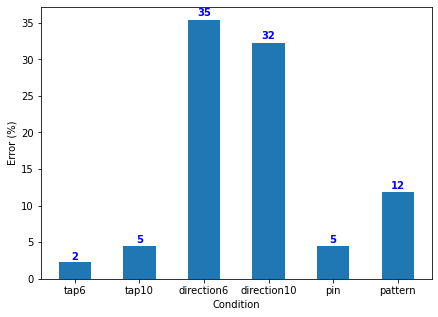

In [6]:
successRates = {}

def computeErrorRate(lst):
    errors = len(list(filter(lambda x: x['endState'] == 'FAILURE', lst)))
    return (errors / len(lst)) * 100

for method in methodsDict:
    successRates[method] = computeErrorRate(methodsDict[method])


fig, ax = plt.subplots(figsize=(7,5))
ax.set_ylabel('Error (%)')
ax.set_xlabel('Condition')

x = list(successRates.keys())
y = list(successRates.values())


rects = ax.bar(x, y, 0.5)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % round(height),  ha='center', va='bottom' , color='blue', fontweight='bold')

### Graph Average Authentication Time for Successful Sessions

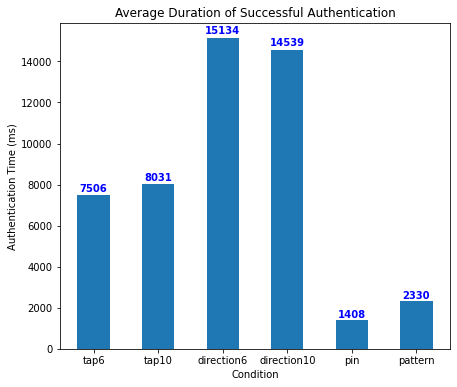

In [7]:
def computeAverageSuccessTime(lst):
    successfulAuths = list(filter(lambda x: x['endState']=='SUCCESS', lst))
    total = 0
    for val in lst:
        total+= val['elapsedTimeInMilliseconds']
    return total/len(successfulAuths)

for method in methodsDict:
    successRates[method] = computeAverageSuccessTime(methodsDict[method])

fig, ax = plt.subplots(figsize=(7,6))
ax.set_ylabel('Authentication Time (ms)')
ax.set_xlabel('Condition')
ax.set_title('Average Duration of Successful Authentication')

x = list(successRates.keys())
y = list(successRates.values())
rects = ax.bar(x, y, 0.5)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % round(height),  ha='center', va='bottom', color='blue', fontweight='bold')

### Time Distribution

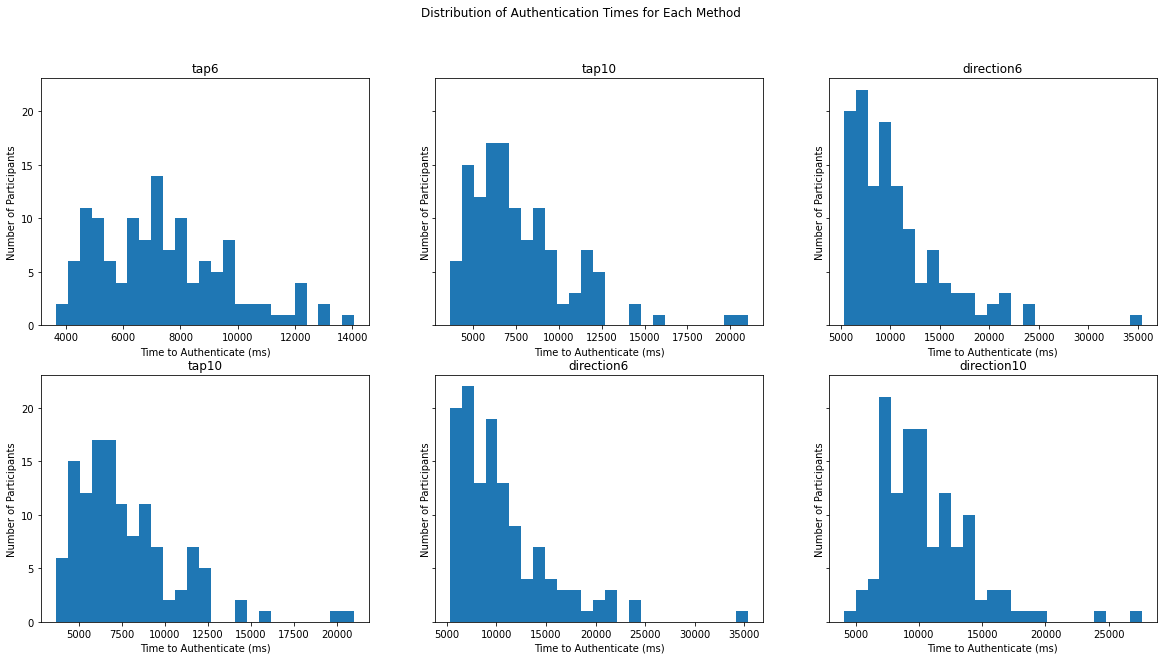

In [10]:
successfulAuths = methodsDict.copy()

for item in successfulAuths:
    successfulAuths[item] = list(filter(lambda x: x['endState']=='SUCCESS', successfulAuths[item]))
successfulAuthsTimeList = list(map(lambda x: {x:list(map(lambda y: y['elapsedTimeInMilliseconds'], successfulAuths[x]))}, successfulAuths))

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(20,10))
fig.suptitle('Distribution of Authentication Times for Each Method')

n_bins = 25


for i in range(0,2):
    for j in range(0,3):
        axs[i,j].hist(successfulAuthsTimeList[i+j].values(), bins=n_bins)
        axs[i,j].set_title(list(successfulAuthsTimeList[i+j].keys())[0])
        axs[i,j].set_xlabel('Time to Authenticate (ms)')
        axs[i,j].set_ylabel('Number of Participants')


### Statistical Tests - Repeated Measures One-Way ANOVA

In [54]:
# Parses files and puts data in a format for statistical tests


def getMethod(auth):
    if auth['method'] == 'tap':
        if auth['numTicks'] == '6':
            return 'tap6'
        else:
            return 'tap10'
    elif auth['method'] == 'direction':
        if auth['numTicks'] == '6':
            return 'direction6'
        else:
            return 'direction10'
    elif auth['method'] == 'PATTERN':
        return 'pattern'
    elif auth['method'] == 'PIN':
        return 'PIN'

def fileToTable(i,f, end=None):
    totalRows=[]
    for key in f:
        for auth in f[key]:
            if auth['endState'] != 'ABORTED':
                if end==None:
                    totalRows.append([i, getMethod(auth), auth['elapsedTimeInMilliseconds'], auth['endState']])
                elif auth['endState'] == end:
                        totalRows.append([i, getMethod(auth), auth['elapsedTimeInMilliseconds'], auth['endState']])

    return totalRows


def createFileTable(end=None):
    fileTable = [['participant', 'method', 'elapsedTimeInMilliseconds', 'endState']]
    for index, file in enumerate(files):
        fileTable += fileToTable(index, file, end)
    return fileTable

totalFileTable = createFileTable()
successFileTable = createFileTable(end='SUCCESS')
failureFileTable = createFileTable(end='FAILURE')


def createTempFileFromTable(fileName, table):
    with open(name, 'w') as f:
        for line in successFileTable:
            f.write(','.join([str(line[0]), line[1], str(line[2]), str(line[3]), '\n']))


In [72]:
def mean(lst):
    return sum(lst)/len(lst)


df = pd.read_csv('successTemp.csv')
print(AnovaRM(df, 'elapsedTimeInMilliseconds', 'participant', within=['method'], aggregate_func=mean))


# print(f'ANOVA: Number of Errors\nF-statistic: {f_stat_errorCount.statistic}\np-value: {f_stat_errorCount.pvalue}\n\n')
# print(f'ANOVA: Successful Authentication Times\nF-statistic: {f_stat_authTime.statistic}\np-value: {f_stat_authTime.pvalue}')

90     1187
91     1093
92     1037
93      874
94     1315
95     1120
96      724
97     1034
98      885
99     1224
100    1561
101    1115
102    1347
103     828
104     926
105    1536
106    1727
107    1138
Name: elapsedTimeInMilliseconds, dtype: int64
1148.388888888889
72     7406
73     9375
74     7749
75     9284
76     6816
77     8952
78     8053
79    11992
80     9441
81    10551
82     7572
83    14786
84     6012
85     5387
86     9186
87     4048
88     9633
89    13435
Name: elapsedTimeInMilliseconds, dtype: int64
8871.0
18    23411
19    10627
20     9835
21     9285
22     9123
23     8361
24     8861
25    11390
26    10628
27    10311
28     5407
29     6550
30     6183
31     9133
32     9361
33     8055
34     6964
35     8790
Name: elapsedTimeInMilliseconds, dtype: int64
9570.833333333334
36    2949
37    1522
38    1965
39    2195
40    2406
41    2227
42    2452
43    1583
44    1502
45    1865
46    1895
47    1986
48    1214
49    1298
50    1392
51    